In [1]:
import numpy as np
import pandas as pd
import os
import joblib
import pickle
import math
import ast
from scipy.stats import median_abs_deviation, hypergeom, mannwhitneyu
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
# Saving plots with editable text
plt.rcParams['pdf.fonttype'] = 42  # TrueType fonts (editable text)

In [2]:
import dictys
from utils_custom import *
from pseudotime_curves import *
from episode_plots import *
from episodic_dynamics import *
from config import *

In [3]:
config = Config()

# Cell state distributions per fate

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/dynamic.h5')

#### Get cell state labels for each window

In [5]:
cell_labels = pd.read_csv(config.CELL_LABELS, header=0)
display(cell_labels.index)

RangeIndex(start=0, stop=28494, step=1)

In [6]:
cell_assignment_matrix = dictys_dynamic_object.prop["sc"]["w"]
state_labels_in_window = {}
for window_idx in range(cell_assignment_matrix.shape[0]):
    indices_of_cells_present_in_window = np.where(
        cell_assignment_matrix[window_idx] == 1
        )[0] #these indices start from 0
    state_labels_in_window[window_idx] = [
        cell_labels.iloc[int(idx)]['Cluster'] for idx in indices_of_cells_present_in_window
        ]

In [19]:
state_count_per_window = window_labels_to_count_df(state_labels_in_window)
state_count_per_window = state_count_per_window.drop(index=['ActB-1', 'earlyActB'])

#### Always use pseudotime to bin windows instead of window indices - as pseudotime is the temporal spread/distribution and not the indices

In [12]:
PB_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(98, 147, 1)) + [2]
GC_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(147, 193, 1)) + [3]
PB_post_bifurcation_window_indices = [0] + list(range(98, 147, 1)) + [2]
GC_post_bifurcation_window_indices = [0] + list(range(147, 193, 1)) + [3]

In [13]:
# Define distinct colors for better visibility
colors_cell_count = {
    'ActB-1': '#87CEFA',     # lightskyblue
    'ActB-2': '#1E90FF',     # dodgerblue
    'ActB-3': '#00008B',     # darkblue
    'ActB-4': '#9370DB',     # mediumorchid
    'GC-1': '#7BDE7B',       # custom light green
    'GC-2': '#008000',       # green
    'PB-2': '#BB3636',       # custom red
    'earlyActB': '#008080',   # teal
    'earlyPB': '#F08080'   # lightcoral
}

In [14]:
pseudotime_values_of_windows = AlignTimeScales(dictys_dynamic_object, trajectory_range=[0, 2]).pseudotime_of_windows()

Time points per bin: [15, 17, 3, 3, 4, 3, 5, 1]
Total cells per bin: [np.float64(999.8), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0)]


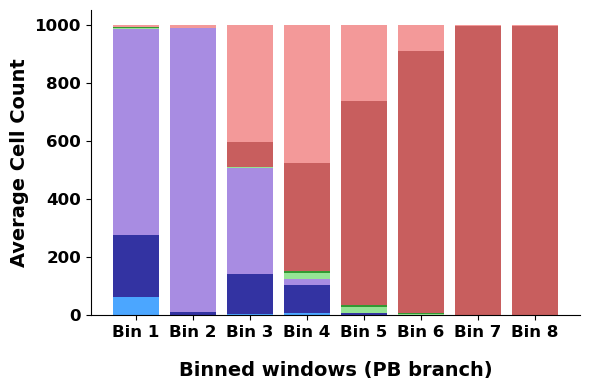

In [15]:
# Create a new dataframe with only the columns in PB_fate_window_indices
df_plot = state_count_per_window[PB_post_bifurcation_window_indices]
# Create time bins
n_bins = 8  # Adjust this number as needed
x = [pseudotime_values_of_windows[i] for i in PB_post_bifurcation_window_indices]
x_min, x_max = min(x), max(x)

# Create bin edges
bin_edges = np.linspace(x_min, x_max, n_bins + 1)
bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(n_bins)]

# Initialize binned data and count time points per bin
binned_data = {state: [0] * n_bins for state in df_plot.index}
bin_counts = [0] * n_bins  # Track how many time points are in each bin

# Aggregate data into bins
for i, time_point in enumerate(x):
    # Find which bin this time point belongs to
    bin_idx = np.digitize(time_point, bin_edges) - 1
    bin_idx = max(0, min(bin_idx, n_bins - 1))  # Ensure within bounds
    
    # Add counts for each cell state to the appropriate bin
    for state in df_plot.index:
        binned_data[state][bin_idx] += df_plot.loc[state].values[i]
    
    bin_counts[bin_idx] += 1

# Average the counts within each bin (so each bin represents average composition)
for state in df_plot.index:
    for bin_idx in range(n_bins):
        if bin_counts[bin_idx] > 0:
            binned_data[state][bin_idx] = binned_data[state][bin_idx] / bin_counts[bin_idx]

# Plot
plt.figure(figsize=(6, 4))
plt.style.use('default')
plt.grid(False)

# Initialize bottom array for stacking
bottom = [0] * n_bins

# Plot each cell state as a layer in the stacked bar
for state in df_plot.index:
    y = binned_data[state]
    plt.bar(range(n_bins), y,
            label=state,
            color=colors_cell_count[state],
            bottom=bottom,
            alpha=0.8)
    
    # Update bottom for next stack layer
    bottom = [bottom[i] + y[i] for i in range(n_bins)]

plt.xlabel('Binned windows (PB branch)', fontsize=14, fontweight='bold', labelpad=15)
plt.ylabel('Average Cell Count', fontsize=14, fontweight='bold')
plt.xticks(range(n_bins), [f"Bin {i+1}" for i in range(n_bins)], fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# save figure
#plt.savefig(os.path.join(output_folder, 'fig4_state_count_PB_bins.pdf'), dpi=1200)
#plt.show()
# Print bin info for verification
print("Time points per bin:", bin_counts)
print("Total cells per bin:", [sum(binned_data[state][i] for state in df_plot.index) for i in range(n_bins)])

# Pseudotime curves of TF expression and activity

In [7]:
exp_curves_dy, exp_curves_dx = SmoothedCurves(dictys_dynamic_object,
    trajectory_range=(0,2),
    num_points=100,
    dist=0.0005,
    sparsity=0.01,
    mode="expression").get_smoothed_curves()

In [8]:
reg_curves_dy, reg_curves_dx = SmoothedCurves(dictys_dynamic_object,
    trajectory_range=(0,2),
    num_points=100,
    dist=0.0005,
    sparsity=0.01,
    mode="regulation").get_smoothed_curves()

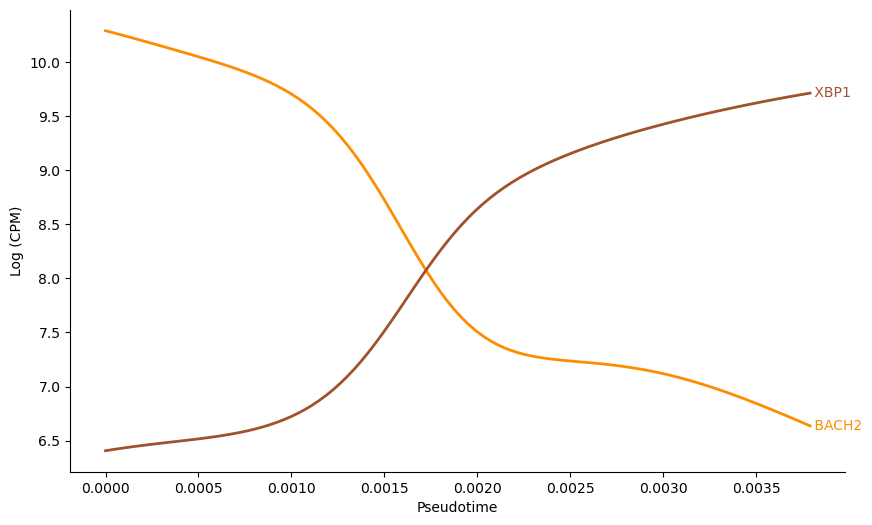

In [20]:
# Plot expression trajectories
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight specific genes
#genes_of_interest = ['CREB3L2','RUNX2']
#genes_of_interest = ['IRF4','PRDM1']
genes_of_interest = ['BACH2','XBP1']
#colors = ['blueviolet','slateblue']
#colors = ['lightcoral','firebrick']
colors = ['darkorange','sienna']

for gene, color in zip(genes_of_interest, colors):
    if gene in exp_curves_dy.index:
        line = plt.plot(exp_curves_dx, exp_curves_dy.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(exp_curves_dx.iloc[-1], exp_curves_dy.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('Log (CPM)')
#save the figure
plt.savefig(os.path.join(config.OUTPUT_FOLDER, 'pb_3rd_wave_tfs_expression.pdf'), dpi=300)
plt.show()

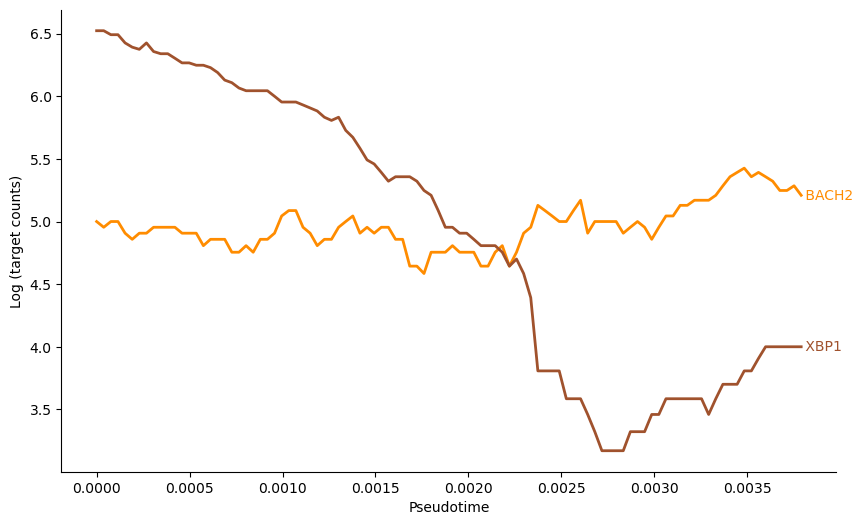

In [21]:
# Plot expression trajectories
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight specific genes
#genes_of_interest = ['CREB3L2','RUNX2']
#genes_of_interest = ['IRF4','PRDM1']
#genes_of_interest = ['BACH2','XBP1']
#colors = ['blueviolet','slateblue']
#colors = ['lightcoral','firebrick']
colors = ['darkorange','sienna']

for gene, color in zip(genes_of_interest, colors):
    if gene in reg_curves_dy.index:
        line = plt.plot(reg_curves_dx, reg_curves_dy.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(reg_curves_dx.iloc[-1], reg_curves_dy.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('Log (target counts)')
#save the figure
plt.savefig(os.path.join(config.OUTPUT_FOLDER, 'pb_3rd_wave_tfs_regulation.pdf'), dpi=300)
plt.show()

# Episodic enrichment plots
### Direct effect enrichment 

In [16]:
df_ep1 = pd.read_csv(config.GC['ep1'])
df_ep2 = pd.read_csv(config.GC['ep2'])
df_ep3 = pd.read_csv(config.GC['ep3'])
df_ep4 = pd.read_csv(config.GC['ep4'])

Filtered to 48 TFs that meet gene count criteria
Further filtered to 6 TFs that meet significance threshold < 0.009


/ocean/projects/cis240075p/asachan/bio_informatics_analysis/B_Cells_human_analysis/src/multiome_dynamic_regulation/py_scripts/analysis/episode_plots.py:423: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


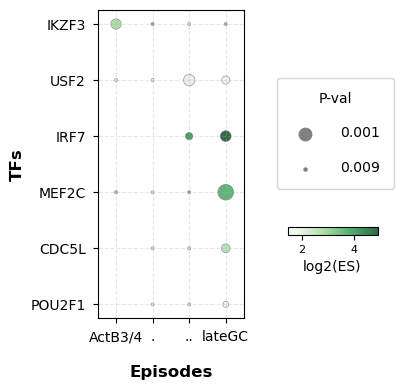

In [ ]:
# Define your desired TF order

# custom_tf_order_prdm1 = ['BPTF', 'SP1', 'BATF3', 'RBPJ', 'IKZF2']
# custom_tf_order_irf4 = ['MBD2', 'IKZF2', 'RBPJ', 'TCF12', 'BACH1', 'HMG20A']
# custom_tf_order_ets1_sig = ['Hdac2', 'Nfkb1', 'Ets1', 'Sin3a', 'Max']
# custom_tf_order_ikzf1_all = ['Ep300', 'E2f2', 'Klf6', 'Nfe2', 'Taf1', 'Nr4a2', 'Bhlhe40', 'Rad21', 'Klf2', 'Ctcf']
# custom_tf_order_ets1_all = ['Myc', 'Nfe2', 'Ets1', 'Elf1', 'Srf', 'Max', 'E2f2', 'Bhlhe41', 'Sp4']
# custom_tf_order_z11_pb = ['CREB3L2', 'MEF2C', 'TFEC', 'TEAD2', 'IRF8', 'IRF9']
custom_tf_order_z11_gc = ['IKZF3', 'USF2', 'IRF7', 'MEF2C', 'CDC5L', 'POU2F1']

# Use it in the plot
fig, plot_data, plotted_tfs = plot_tf_episodic_enrichment_dotplot(
    dfs=[df_ep1, df_ep2, df_ep3, df_ep4],
    episode_labels=['ActB3/4', '.', '..', 'lateGC'],
    figsize=(4.5, 4), #breadth by length
    p_value_threshold=0.009,
    min_significance_threshold=0.009, 
    min_targets_in_lf=2,
    min_targets_dwnstrm=2,
    cmap_name="Greens",
    tf_order=custom_tf_order_z11_gc,
    figure_title=None,
    log_scale=True
)
# save the plot
#fig.savefig(os.path.join(config.OUTPUT_FOLDER, "z11_ee_gc.pdf"), dpi=300)

# Chromatin level TF activity over pseudotime